### Importing necessary libraries

In [1]:
!pip install arabic_reshaper
!pip install pandasql
import arabic_reshaper


In [2]:
import torch

In [3]:
from matplotlib.gridspec import GridSpec
from scipy import stats


In [4]:
#features=list(features)
!pip install python-bidi
from bidi.algorithm import get_display

In [5]:
import csv as csv
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from scipy.stats import skew
from collections import OrderedDict
from sklearn import preprocessing
from datetime import datetime


In [6]:

import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Actications
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
from keras import backend as K

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xlrd
warnings.filterwarnings("ignore")

In [9]:
from sklearn.preprocessing import LabelEncoder

### IMporting data

In [10]:
features = pd.read_csv('/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/features.csv')

In [11]:
sample_submission = pd.read_csv('/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')

In [12]:
stores = pd.read_csv('/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/stores.csv')

In [13]:
test = pd.read_csv('/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/test.csv')

In [14]:
train= pd.read_csv('/content/drive/MyDrive/walmart-recruiting-store-sales-forecasting/train.csv')

### Then we merge stores data with features 

In [15]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [16]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [17]:
feat_sto['Week'] = feat_sto.Date.dt.week 
feat_sto['Month'] = feat_sto.Date.dt.month 

feat_sto['Year'] = feat_sto.Date.dt.year

### After that we merge features + stores data with sales data

In [18]:
train_detail = train.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [19]:
test_detail = test.merge(feat_sto, 
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

We check precence of null values , then drop fiields that contain large percent of nulls

In [20]:
train_detail.isna().mean()

Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
Type            0.000000
Size            0.000000
Week            0.000000
Month           0.000000
Year            0.000000
dtype: float64

In [21]:
test_detail.isna().mean()

Store           0.000000
Dept            0.000000
Date            0.000000
IsHoliday       0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.001295
MarkDown2       0.248792
MarkDown3       0.085422
MarkDown4       0.112007
MarkDown5       0.000000
CPI             0.331659
Unemployment    0.331659
Type            0.000000
Size            0.000000
Week            0.000000
Month           0.000000
Year            0.000000
dtype: float64

In [22]:
train_detail = train_detail.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

In [23]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,9,3,2010


An info of interest if we have holiday weeks info 

In [24]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2011) & (test_detail.Week==16), 'IsHoliday'] = True
test_detail.loc[(test_detail.Year==2012) & (test_detail.Week==14), 'IsHoliday'] = True

### Then we start studying the insights
Then we start by sales per week along of the 3 years of study

the following lines contain answer of Q1 and Q2

###Q1 : Imagine that you are a data scientist in Walmart and your first task is to analyze this dataset. Provide the business insights you find most compelling in this dataset. *


in the next lines we study insights and effect of seasonality , stores , department  and other factors , I will study distribution of each variable and its relationship with our dependent variables (weekly sales)

First we study seasonality effect ( , we study change in sales per week of year

###Q2 : What is the effect of seasonality on store sales? *


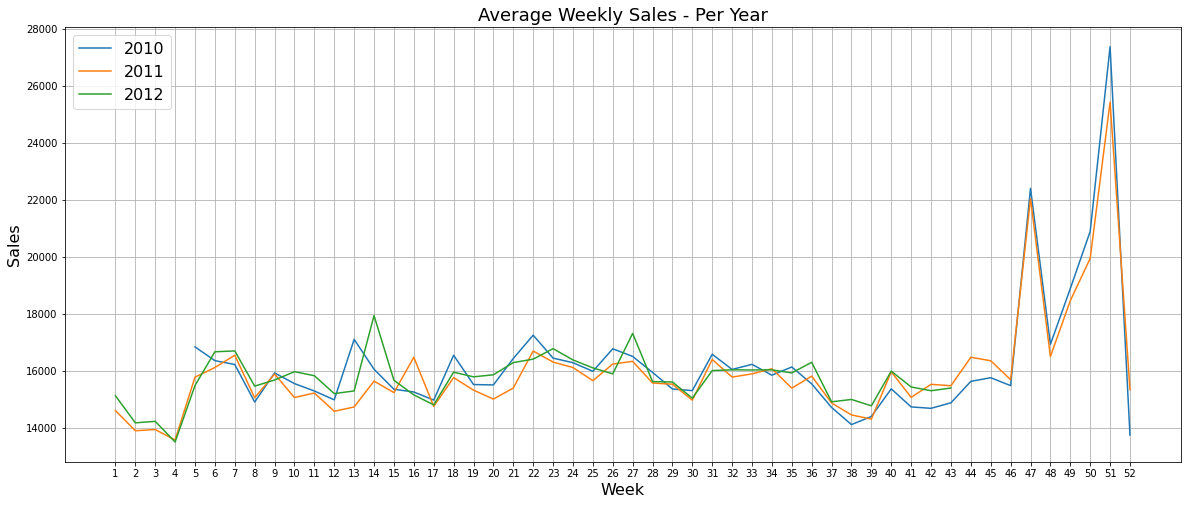

In [25]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

We notice the weeks increasing in week 47 due to thanks giving week and also the last week in the year due to also christmas 

then we study seasonality on monthly basis

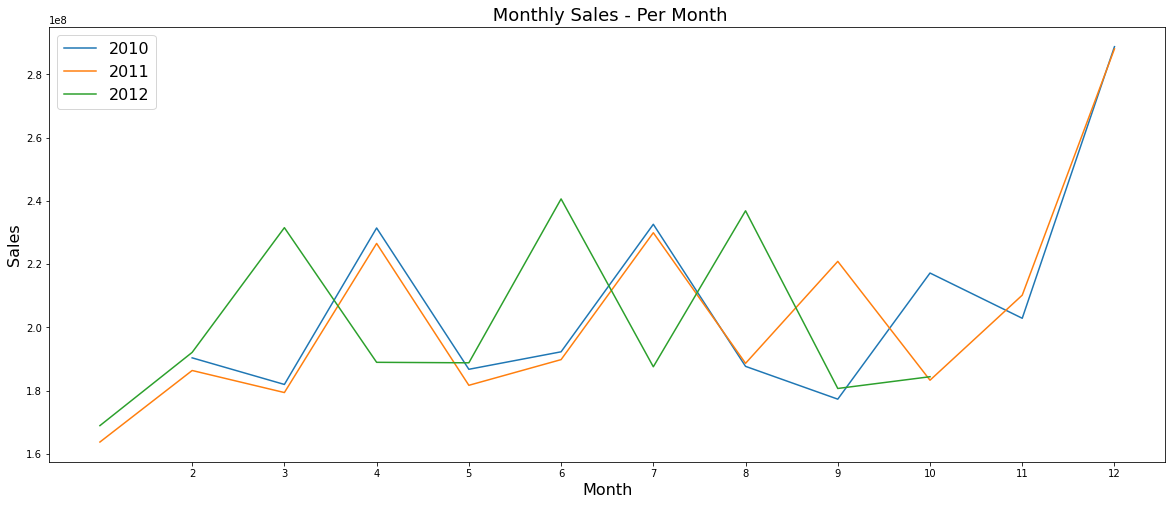

In [26]:
monthly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Month']).sum()
monthly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Month']).sum()
monthly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Month']).sum()

plt.figure(figsize=(20,8))
sns.lineplot(monthly_sales_2010.index, monthly_sales_2010.values)
sns.lineplot(monthly_sales_2011.index, monthly_sales_2011.values)
sns.lineplot(monthly_sales_2012.index, monthly_sales_2012.values)
plt.grid()
plt.grid()
plt.xticks(np.arange(2, 13, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)

plt.title(' Monthly Sales - Per Month', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.show()

we notice the increase in sales is april , and july in years 2011 , 2012 , but in 2013 we find increase in march , june and august , this is generally due to summer months 

then we study sales per store

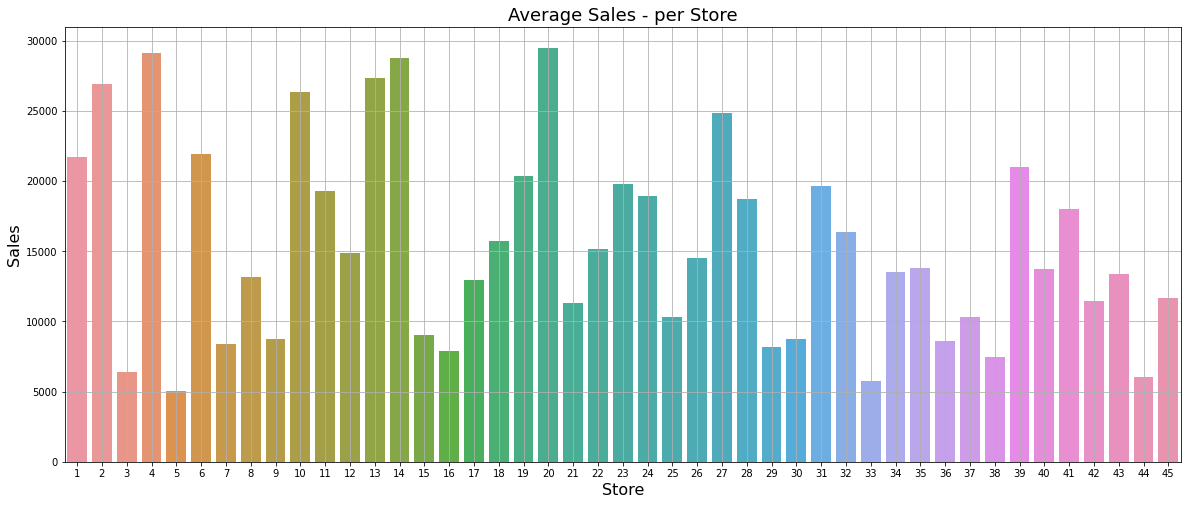

In [27]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

We notice that stores with  2 , 4 , 13 , 14 , 20 have the peak average sales 

then we study average sales per department 

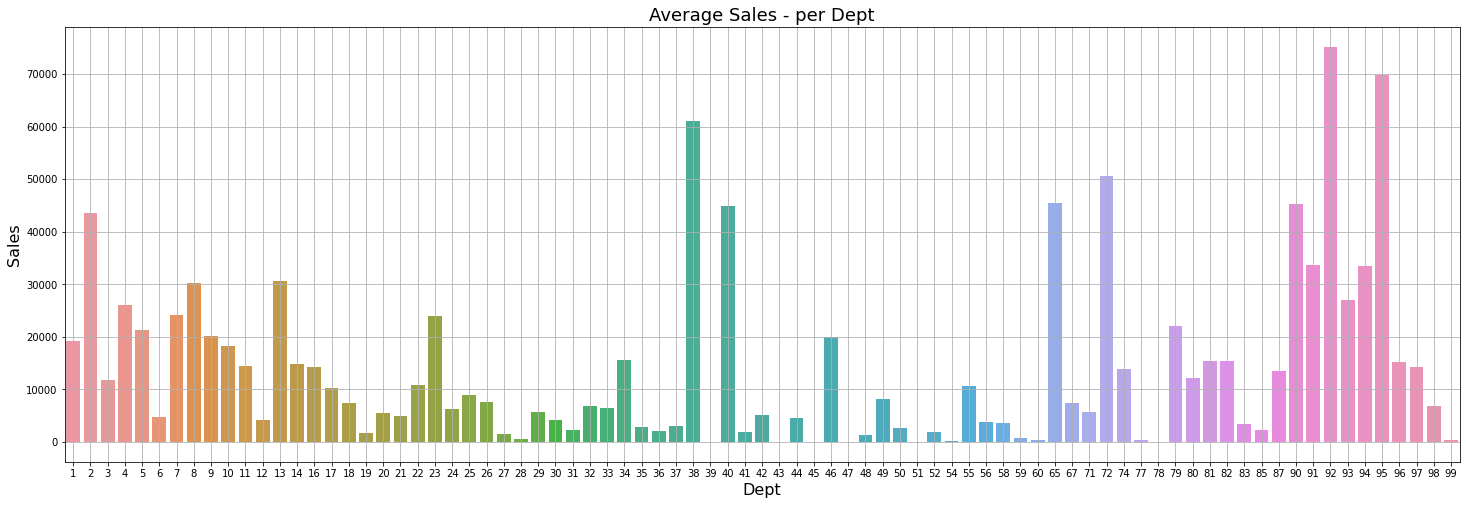

In [28]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values)
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

we find department 38 , 92 , and 95 ahve the largest average sales

In [29]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    plt.title('Distribution of ' + feature)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.barplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

we study average of sales as per holidays , also as per type 

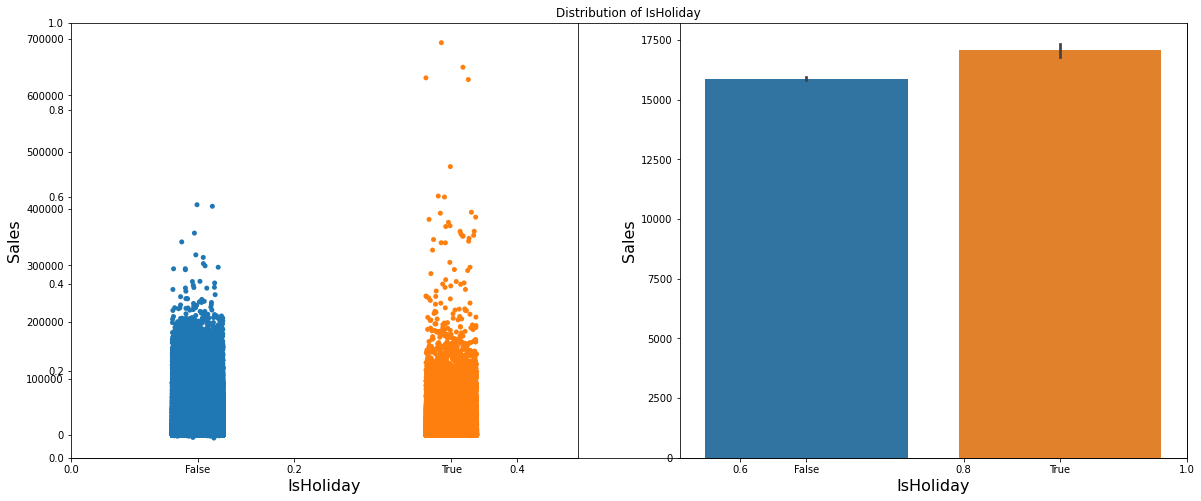

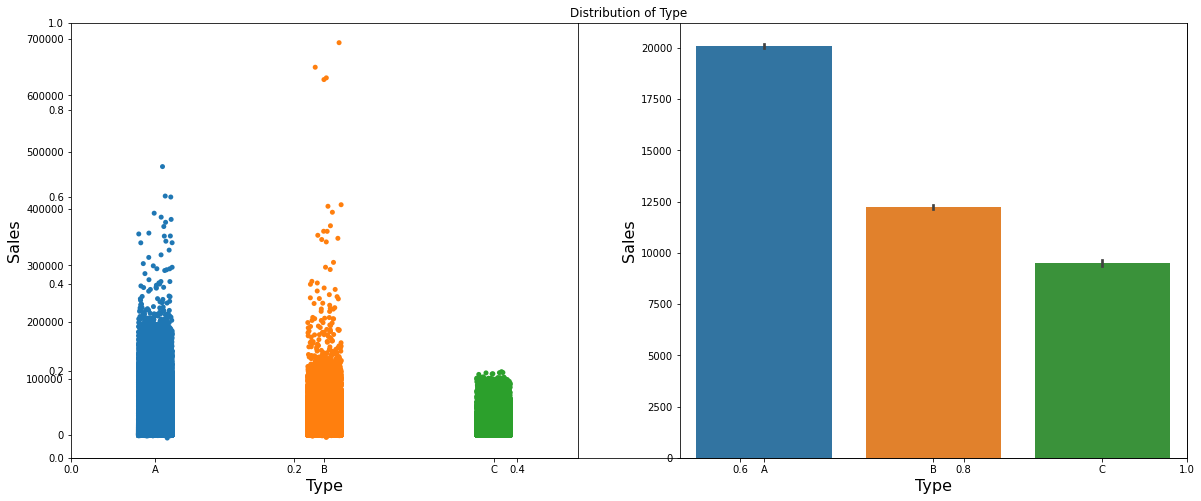

In [30]:
for i in train_detail.select_dtypes(include=['object' , 'bool' ] ).columns:

   make_discrete_plot(i)

In [31]:
train_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
 11  Week          421570 non-null  int64         
 12  Month         421570 non-null  int64         
 13  Year          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(6), object(1)
memor

then we study distribution of scale features , and scatter plot between them and weekly sales

In [32]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(1,2)
    
    

    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'green')

    plt.title('Distribution\n' + feature)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,1]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

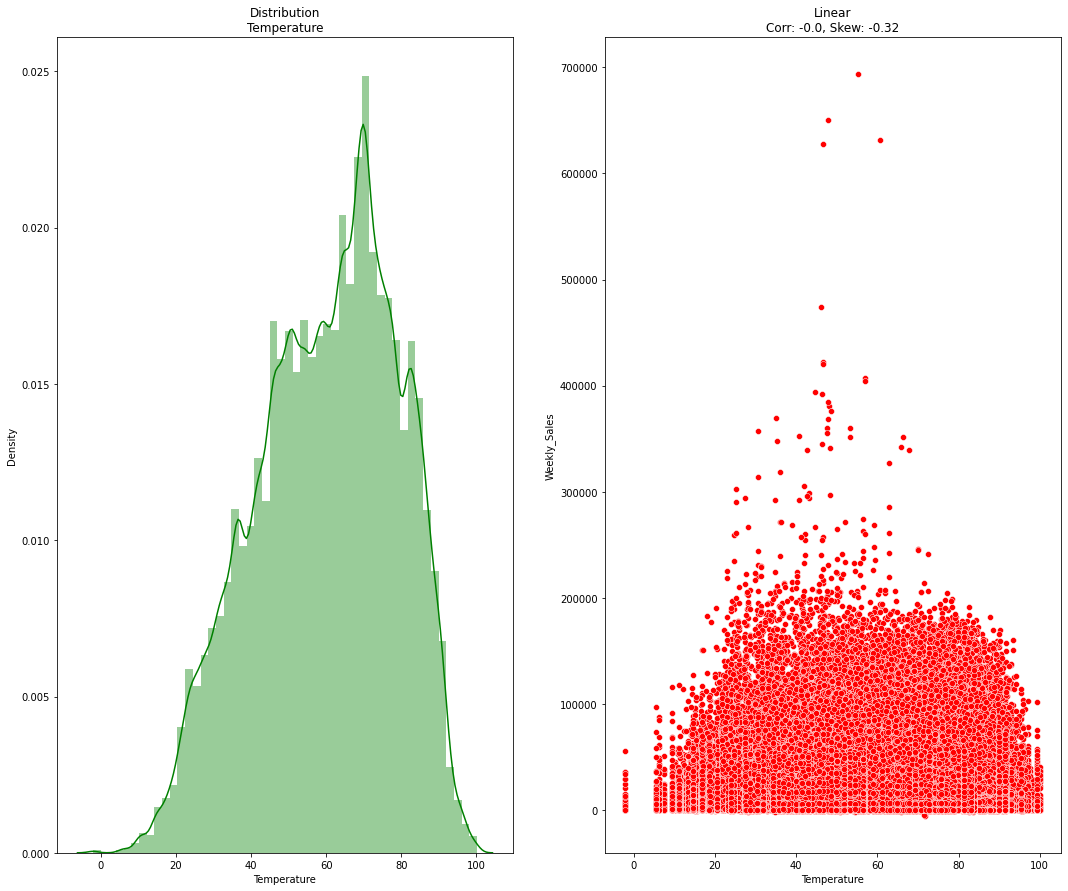

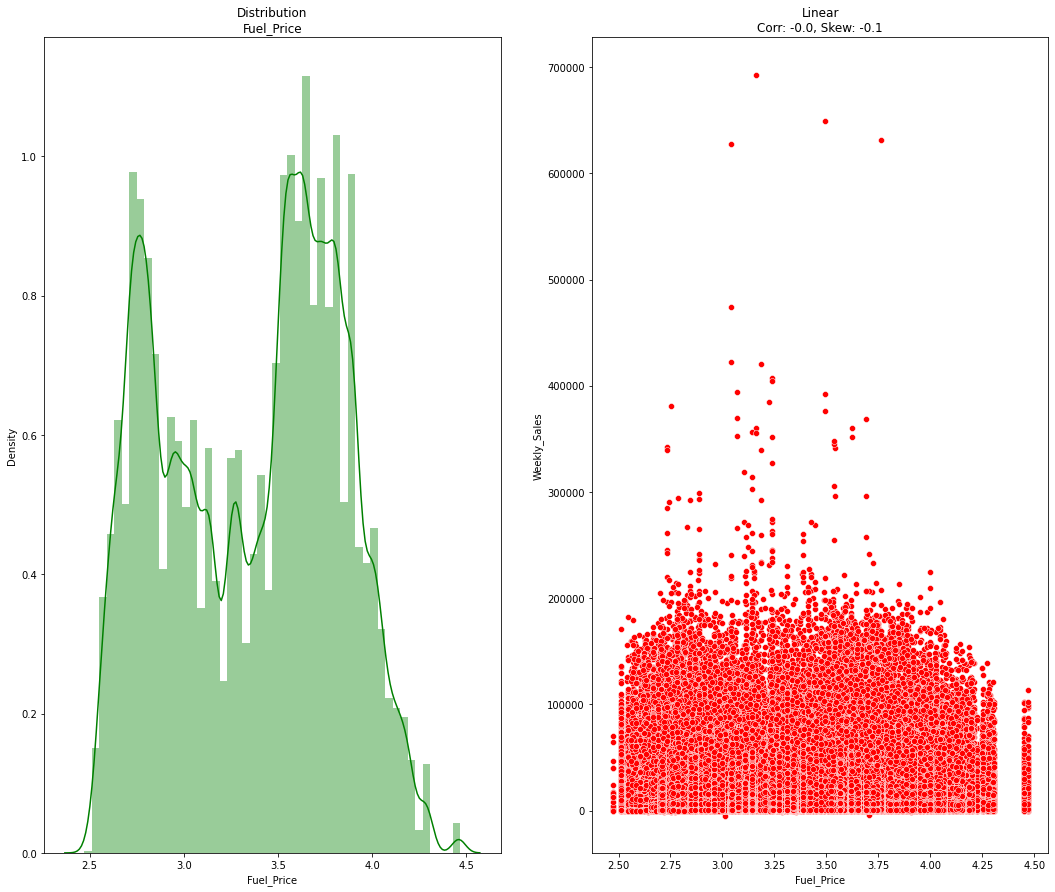

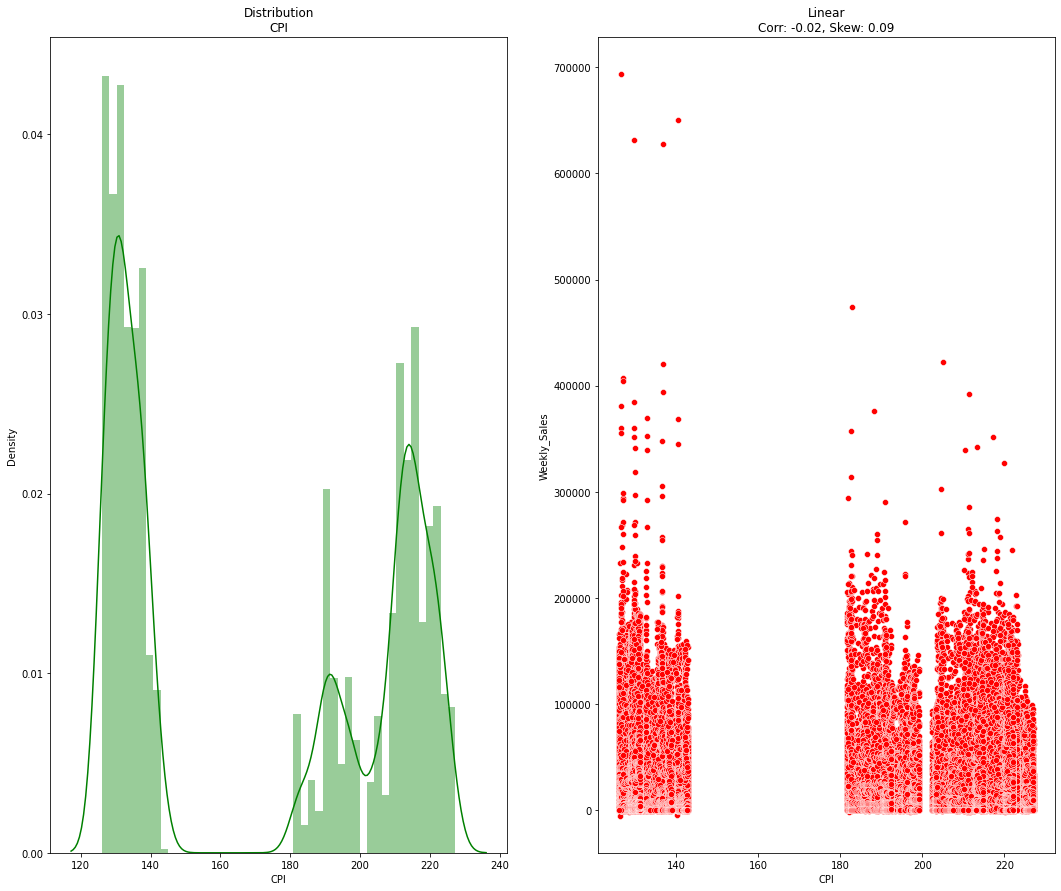

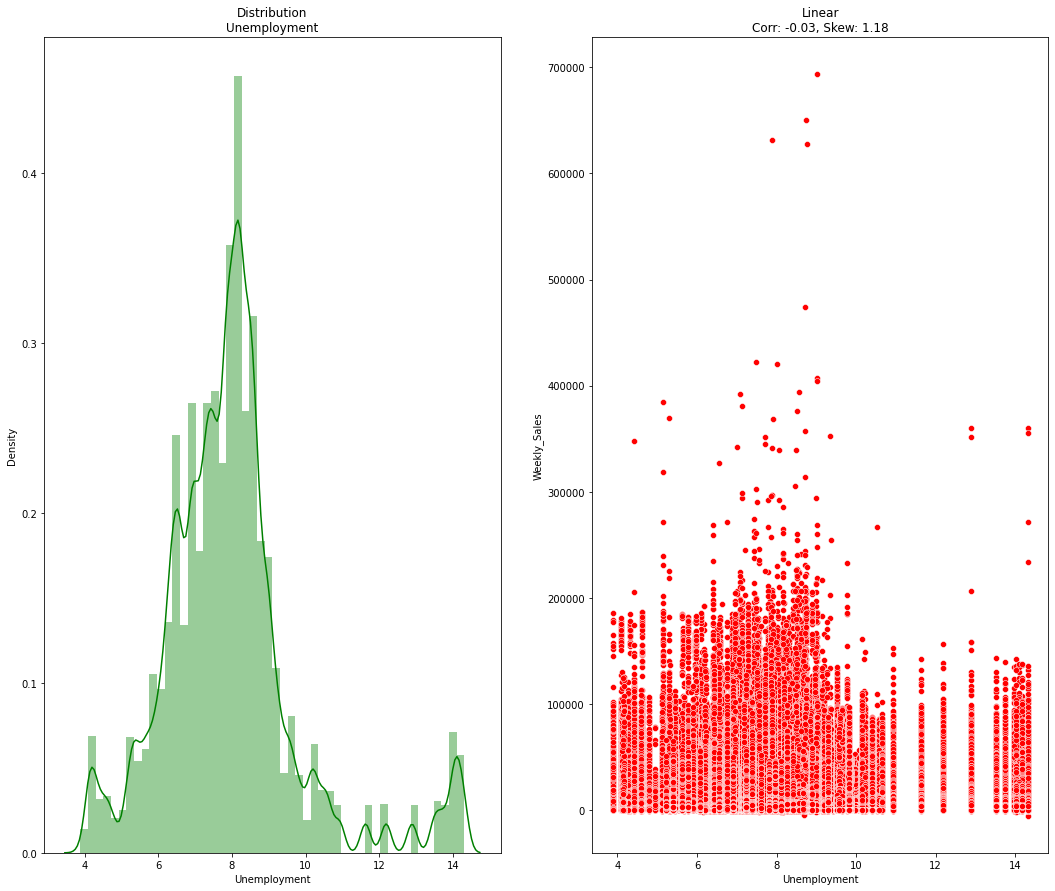

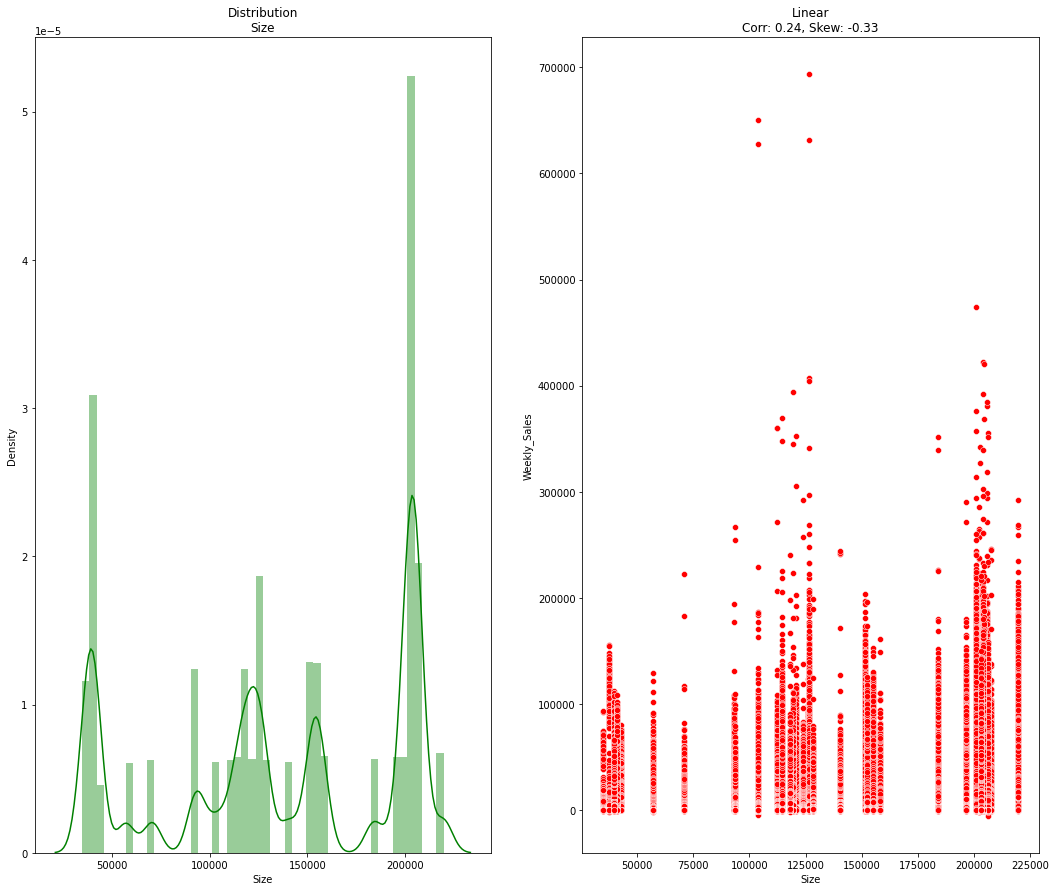

In [33]:
for i in train_detail.select_dtypes(include=['int' , 'float' ] ).drop(columns=['Weekly_Sales' ,'Year' , 'Month' , 'Week' , 'Store' , 'Dept']).columns:

  make_continuous_plot(i)
  

###Q3 : Describe your approach if you have been asked to build an ML model to forecast the sales. *


In [34]:
train_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   Type          421570 non-null  object        
 10  Size          421570 non-null  int64         
 11  Week          421570 non-null  int64         
 12  Month         421570 non-null  int64         
 13  Year          421570 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(6), object(1)
memor

In [35]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Week,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,5,2,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,6,2,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,7,2,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,8,2,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,9,3,2010


First we start with transforming the scale features to get rid of the skewness

In [36]:
non_scale=['Store' , 'Dept' , 'Type' , 'Week' , 'Month' ,'Year' ]

In [37]:
scale=['Temperature' ,'CPI' ,'Unemployment' ,'Size']

In [38]:
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)

In [39]:
x = train_detail.loc[: , non_scale + scale]

In [40]:
y = train_detail['Weekly_Sales']

Then , get indicators for each level of the nominal and ordinal variables

In [41]:
x_final=pd.get_dummies(x,columns=non_scale, drop_first=True) .replace(np.nan,0)


In [42]:
 x_final.loc[:,scale]=pt.fit_transform(x_final.loc[:,scale] )

In [43]:
Y = (y).to_numpy().reshape((len(y),1))

Y=pt.fit_transform(Y )


### Fitting model

the final step before modeling is to split data into train and test sets to train and test ou model


In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_final, Y, test_size=0.3)

We start by a random forest regression model to have an inferrence about prediction quality and to specify the most important variables in prediction process

We take R- squared goodness of fit as a measure of model quality

In [45]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators= 50 )
rf.fit(X_train, y_train)

print('Training Accuracy: {:.2f} '.format(rf.score(X_train, y_train)*100))
print('test Accuracy: {:.2f} '.format(rf.score(X_test, y_test)*100))

Training Accuracy: 99.37 
test Accuracy: 79.41 


Since R- squared threshold is 70% , so 79% on test set is good enough to go ahead 

WE detect the most important features to go ahead with them and search a better model , since it may be computational expensive , so we need to minimize the size of data

### So we rank features according to importance (i.e amount of variability explained in the dependent variable by each feature)


In [46]:
features = x_final.columns

In [47]:

importances = rf.feature_importances_
indices = np.argsort(importances) # ranking features according to importance score

the plot below gives the ank of features according to importance score

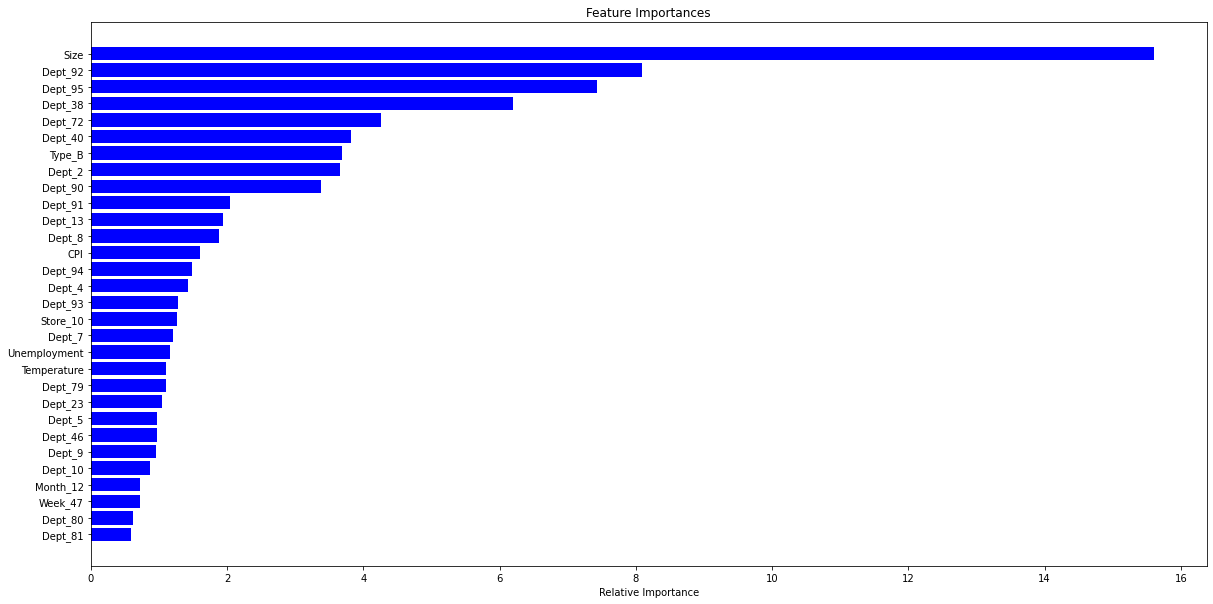

In [48]:
# Plotting importance plot (taking top 30 features)
plt.figure(figsize=(20,10))

plt.title('Feature Importances')
plt.barh(range(len(indices[-30:])), importances[indices][-30:]*100, color='b', align='center')
plt.yticks(range(len(indices[-30:])), [get_display(arabic_reshaper.reshape(features[i])) for i in indices[-30:]])
plt.xlabel('Relative Importance')
plt.show()